In [ ]:
## Chapter04から使用するテキストデータをコピーする（事前にChapter04/Sentiment.ipynbを実行してください）
!cp -r ../Chapter04/sisyou_db ./

In [1]:
from collections import Counter

from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import japanize_matplotlib
import networkx as nx
import numpy as np
import pandas as pd
from pyvis.network import Network
from sklearn.preprocessing import normalize
import spacy
from tqdm import tqdm


## モデルのロード
nlp = spacy.load("ja_ginza")

## 類似度の算出・類義語の取得

In [2]:
## 文書中の単語のベクトルを表示する
doc = nlp.tokenizer("猫と犬が仲良く餌を食べている")
print(doc[0].text, doc[0].vector[:10]) #猫
print(doc[2].text, doc[2].vector[:10]) #犬
print(doc[5].text, doc[5].vector[:10]) #餌

print(doc[0], doc[2], doc[0].similarity(doc[2]))
print(doc[0], doc[5], doc[0].similarity(doc[5]))
print(doc[2], doc[5], doc[2].similarity(doc[5]))

猫 [ 0.15373811 -0.1564905   0.16179664 -0.28655747  0.0342402  -0.11897252
 -0.3693792  -0.23002967 -0.10475615 -0.05185191]
犬 [ 0.24548706 -0.01666513  0.3519541  -0.3573019   0.22681548 -0.01640022
 -0.2328325  -0.30443883 -0.37225652 -0.00876428]
餌 [ 0.3722091  -0.26163444  0.06755416 -0.21679421 -0.10845889 -0.11444898
  0.20926419 -0.23945722 -0.38212532 -0.02417345]
猫 犬 0.727109
猫 餌 0.41438472
犬 餌 0.40761146


In [3]:
## 単語を直接指定する
pairs = [
    ("猫", "犬"),
    ("猫", "餌"),
    ("犬", "餌"),
]
for w1, w2 in pairs:
    print(w1, w2, nlp.vocab[w1].similarity(nlp.vocab[w2]))

## 単語が事前学習済単語分散表現に無い場合
print(nlp.vocab["えさ"].vector)

猫 犬 0.727109
猫 餌 0.41438472
犬 餌 0.40761146
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
## 類義語の取得
def get_similarwords(nlp, target_word, n=20):
    query_vecs = np.array([nlp.vocab.get_vector(target_word)])
    keys, best_rows, scores = nlp.vocab.vectors.most_similar(query_vecs, n=n)
    words = [nlp.vocab.strings[key] for key in keys[0]]
    return words

In [5]:
## 類義語の表示
cities = ["東京", "大阪"]
for city in cities:
    print(city, get_similarwords(nlp, city))

東京 ['東京', 'フデカブレ', 'ラバログ', 'マリオットアソシア', '東京都内', 'ミバル', 'ohba', '世田谷区深沢', '埼玉', 'シーホークホテル', 'roppongi', '\ue28e', 'カリーヨシミ', '神奈川', '東八潮', 'シャネルビル', 'トキョ', 'イタマ', '二重橋前駅', 'コッチュケララム']
大阪 ['フデカブレ', 'スティールパンカーニバル', 'マリオットアソシア', 'クリスタルグランツ', 'カンイチ', 'シーホークホテル', '))<<:【', '兵庫', 'シティモ', 'セラーバー', '近鉄日本橋駅', '藤井町', '東京', '奈良県斑鳩町', 'ママカリフォーラム', '三府', 'カルピオ', 'カリーヨシミ', '千旦', '南塚口町']


In [6]:
## 類義語の表示（単語分散表現の差し替え）
## 要 hottoSNS-w2v
nlp_sns = spacy.load("ja_ginza")
## モデル読み込み
w2v_sns = KeyedVectors.load_word2vec_format('./w2v_all_vector200_win5_sgns0.vec', binary=False)

In [7]:
#ベクトル入れ替え
nlp_sns.vocab.reset_vectors(width=w2v_sns.vector_size)
for word in tqdm(w2v_sns.key_to_index.keys()):
    nlp_sns.vocab.set_vector(word, w2v_sns[word])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2067629/2067629 [00:57<00:00, 35882.51it/s]


In [8]:
## 類義語の表示
for city in cities:
    print(city, get_similarwords(nlp_sns, city))

東京 ['東京', '大阪', '名古屋', '福岡', '六本木', '横浜', '大手町', '札幌', '京都', '赤坂', '神奈川', '丸の内', '埼玉', '都内', '日比谷', '台場', '仙台', '静岡', '代々木', '日本橋']
大阪 ['大阪', '名古屋', '東京', '福岡', '関西', '難波', '神戸', '京都', '梅田', 'なんば', '心斎橋', '札幌', '岡山', '兵庫', '仙台', '和歌山', '愛知', '横浜', '京橋', '奈良']


## 単語間類似度ネットワークの構築/可視化

In [9]:
def extract_words(tokens, pos_tags, stopwords):
    words = [token.lemma_ for token in tokens
             if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [10]:
## 労災データの読み込み
df = pd.read_excel("sisyou_db/sisyou_db_h29_01.xlsx", skiprows=[1])

## 頻出用言上位200語（動詞、形容詞）を抽出
include_pos = ('VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう')

counter = Counter()
for text in tqdm(df["災害状況"]):
    tokens = nlp.tokenizer(text)
    words = extract_words(tokens, include_pos, stopwords)
    counter.update(words)

print('count word')
for word, count in counter.most_common(30):
     print('{:>5} {}'.format(count, word))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2695/2695 [00:12<00:00, 223.56it/s]

count word
  754 転倒
  601 負傷
  599 滑る
  379 骨折
  281 強打
  273 おく
  249 落下
  241 崩す
  230 つく
  213 挟む
  210 行う
  205 持つ
  204 向かう
  201 入る
  201 移動
  181 高い
  168 降りる
  168 凍結
  162 誤る
  162 倒れる
  160 取る
  152 負う
  150 落ちる
  143 置く
  142 行く
  135 出る
  133 入れる
  129 歩く
  127 当たる
  124 よる


In [11]:
## 頻出用言200語をベクトル化→単語行列を構築
freq_words = [word for word, _ in counter.most_common(300)
              if nlp.vocab.has_vector(word)]
freq_counts = np.array([counter[word] for word in freq_words])
X = np.array([nlp.vocab.get_vector(word) for word in freq_words])
X = normalize(X, axis=1, norm='l2')

In [12]:
## 単語間類似度行列を構築
cos_sims = X @ X.T
print(cos_sims)

[[ 0.9999999   0.4371737   0.54736555 ...  0.17336373  0.28158027
   0.1028267 ]
 [ 0.4371737   1.0000002   0.18207915 ...  0.22845405  0.15503338
   0.14925355]
 [ 0.54736555  0.18207915  1.0000002  ...  0.17653722  0.20778717
   0.01733091]
 ...
 [ 0.17336373  0.22845405  0.17653722 ...  1.          0.10747059
   0.20741206]
 [ 0.28158027  0.15503338  0.20778717 ...  0.10747059  0.9999998
  -0.00152789]
 [ 0.1028267   0.14925355  0.01733091 ...  0.20741206 -0.00152789
   1.0000005 ]]


In [13]:
## 類似度行列から，単語間類似度の重みを算出
def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [(word, {'weight': count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc):
    Xc_max = Xc.max()
    cutoff = 0.6 * Xc_max
    weights = [(words[i], words[j], 0.1 * Xc[i,j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

In [14]:
## 単語間類似度ネットワークを構築
def create_network(words, word_counts, Xc):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    # pyvis_G.from_nx(G) # pyvisライブラリ現状では，属性が反映されない．
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

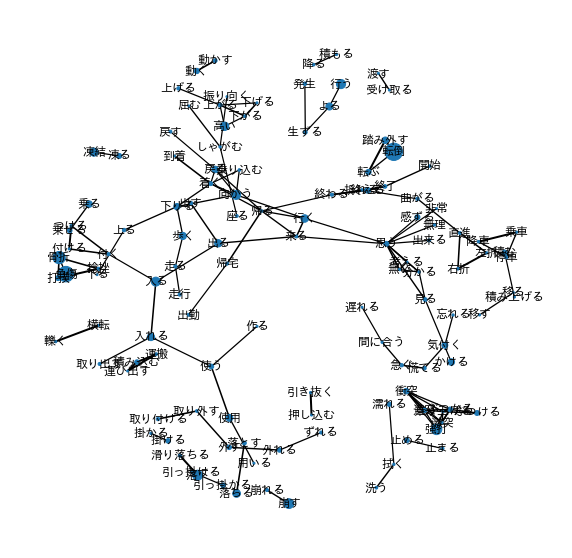

In [15]:
## ネットワークを表示・可視化
G = create_network(freq_words, freq_counts, cos_sims)
pyplot_network(G)
pyvis_G = nx2pyvis_G(G)
pyvis_G.show("mygraph.html")